# PROBLEMA VIAJERO COLOMBIAN VERSION.

In [13]:
#Importamos las librerias Necesarias para el desarollo Utlizando Algoritmos Geneticos
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import pyproj 
from pygad import gann
from matplotlib import animation, rc
import pandas as pd
import random
import itertools
import imageio
import os

### Clase AntColony para el desarrollo del Ejercicio.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import time

import warnings

warnings.filterwarnings("ignore")


class AntColonyOptimizer:
    def __init__(self, ants, evaporation_rate, intensification, alpha=1.0, beta=0.0, beta_evaporation_rate=0,
                 choose_best=.1):
        """
        Ant colony optimizer.  Traverses a graph and finds either the max or min distance between nodes.
        :param ants: number of ants to traverse the graph
        :param evaporation_rate: rate at which pheromone evaporates
        :param intensification: constant added to the best path
        :param alpha: weighting of pheromone
        :param beta: weighting of heuristic (1/distance)
        :param beta_evaporation_rate: rate at which beta decays (optional)
        :param choose_best: probability to choose the best route
        """
        # Parameters
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.pheromone_intensification = intensification
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.beta_evaporation_rate = beta_evaporation_rate
        self.choose_best = choose_best

        # Internal representations
        self.pheromone_matrix = None
        self.heuristic_matrix = None
        self.probability_matrix = None

        self.map = None
        self.set_of_available_nodes = None

        # Internal stats
        self.best_series = []
        self.best = None
        self.fitted = False
        self.best_path = None
        self.fit_time = None

        # Plotting values
        self.stopped_early = False

    def __str__(self):
        string = "Ant Colony Optimizer"
        string += "\n--------------------"
        string += "\nDesigned to optimize either the minimum or maximum distance between nodes in a square matrix that behaves like a distance matrix."
        string += "\n--------------------"
        string += "\nNumber of ants:\t\t\t\t{}".format(self.ants)
        string += "\nEvaporation rate:\t\t\t{}".format(self.evaporation_rate)
        string += "\nIntensification factor:\t\t{}".format(
            self.pheromone_intensification)
        string += "\nAlpha Heuristic:\t\t\t{}".format(self.heuristic_alpha)
        string += "\nBeta Heuristic:\t\t\t\t{}".format(self.heuristic_beta)
        string += "\nBeta Evaporation Rate:\t\t{}".format(
            self.beta_evaporation_rate)
        string += "\nChoose Best Percentage:\t\t{}".format(self.choose_best)
        string += "\n--------------------"
        string += "\nUSAGE:"
        string += "\nNumber of ants influences how many paths are explored each iteration."
        string += "\nThe alpha and beta heuristics affect how much influence the pheromones or the distance heuristic weigh an ants' decisions."
        string += "\nBeta evaporation reduces the influence of the heuristic over time."
        string += "\nChoose best is a percentage of how often an ant will choose the best route over probabilistically choosing a route based on pheromones."
        string += "\n--------------------"
        if self.fitted:
            string += "\n\nThis optimizer has been fitted."
        else:
            string += "\n\nThis optimizer has NOT been fitted."
        return string

    def _initialize(self):
        """
        Initializes the model by creating the various matrices and generating the list of available nodes
        """
        assert self.map.shape[0] == self.map.shape[1], "Map is not a distance matrix!"
        num_nodes = self.map.shape[0]
        self.pheromone_matrix = np.ones((num_nodes, num_nodes))
        # Remove the diagonal since there is no pheromone from node i to itself
        self.pheromone_matrix[np.eye(num_nodes) == 1] = 0
        self.heuristic_matrix = 1 / self.map
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
            self.heuristic_matrix ** self.heuristic_beta)  # element by element multiplcation
        self.set_of_available_nodes = list(range(num_nodes))

    def _reinstate_nodes(self):
        """
        Resets available nodes to all nodes for the next iteration
        """
        self.set_of_available_nodes = list(range(self.map.shape[0]))

    def _update_probabilities(self):
        """
        After evaporation and intensification, the probability matrix needs to be updated.  This function
        does that.
        """
        self.probability_matrix = (self.pheromone_matrix ** self.heuristic_alpha) * (
            self.heuristic_matrix ** self.heuristic_beta)

    def _choose_next_node(self, from_node):
        """
        Chooses the next node based on probabilities.  If p < p_choose_best, then the best path is chosen, otherwise
        it is selected from a probability distribution weighted by the pheromone.
        :param from_node: the node the ant is coming from
        :return: index of the node the ant is going to
        """
        numerator = self.probability_matrix[from_node,
                                            self.set_of_available_nodes]
        if np.random.random() < self.choose_best:
            next_node = np.argmax(numerator)
        else:
            denominator = np.sum(numerator)
            probabilities = numerator / denominator
            next_node = np.random.choice(
                range(len(probabilities)), p=probabilities)
        return next_node

    def _remove_node(self, node):
        self.set_of_available_nodes.remove(node)

    def _evaluate(self, paths, mode):
        """
        Evaluates the solutions of the ants by adding up the distances between nodes.
        :param paths: solutions from the ants
        :param mode: max or min
        :return: x and y coordinates of the best path as a tuple, the best path, and the best score
        """
        scores = np.zeros(len(paths))
        coordinates_i = []
        coordinates_j = []
        for index, path in enumerate(paths):
            score = 0
            coords_i = []
            coords_j = []
            for i in range(len(path) - 1):
                coords_i.append(path[i])
                coords_j.append(path[i + 1])
                score += self.map[path[i], path[i + 1]]
            scores[index] = score
            coordinates_i.append(coords_i)
            coordinates_j.append(coords_j)
        if mode == 'min':
            best = np.argmin(scores)
        elif mode == 'max':
            best = np.argmax(scores)
        return (coordinates_i[best], coordinates_j[best]), paths[best], scores[best]

    def _evaporation(self):
        """
        Evaporate some pheromone as the inverse of the evaporation rate.  Also evaporates beta if desired.
        """
        self.pheromone_matrix *= (1 - self.evaporation_rate)
        self.heuristic_beta *= (1 - self.beta_evaporation_rate)

    def _intensify(self, best_coords):
        """
        Increases the pheromone by some scalar for the best route.
        :param best_coords: x and y (i and j) coordinates of the best route
        """
        i = best_coords[0]
        j = best_coords[1]
        self.pheromone_matrix[i, j] += self.pheromone_intensification

    def fit(self, map_matrix, iterations=100, mode='min', early_stopping_count=20, verbose=True):
        """
        Fits the ACO to a specific map.  This was designed with the Traveling Salesman problem in mind.
        :param map_matrix: Distance matrix or some other matrix with similar properties
        :param iterations: number of iterations
        :param mode: whether to get the minimum path or maximum path
        :param early_stopping_count: how many iterations of the same score to make the algorithm stop early
        :return: the best score
        """
        if verbose:
            print("Beginning ACO Optimization with {} iterations...".format(iterations))
        self.map = map_matrix
        start = time.time()
        self._initialize()
        num_equal = 0

        for i in range(iterations):
            start_iter = time.time()
            paths = []
            path = []

            for ant in range(self.ants):
                current_node = self.set_of_available_nodes[np.random.randint(
                    0, len(self.set_of_available_nodes))]
                start_node = current_node
                while True:
                    path.append(current_node)
                    self._remove_node(current_node)
                    if len(self.set_of_available_nodes) != 0:
                        current_node_index = self._choose_next_node(
                            current_node)
                        current_node = self.set_of_available_nodes[current_node_index]
                    else:
                        break

                path.append(start_node)  # go back to start
                self._reinstate_nodes()
                paths.append(path)
                path = []

            best_path_coords, best_path, best_score = self._evaluate(
                paths, mode)

            if i == 0:
                best_score_so_far = best_score
            else:
                if mode == 'min':
                    if best_score < best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path
                elif mode == 'max':
                    if best_score > best_score_so_far:
                        best_score_so_far = best_score
                        self.best_path = best_path

            if best_score == best_score_so_far:
                num_equal += 1
            else:
                num_equal = 0

            self.best_series.append(best_score)
            self._evaporation()
            self._intensify(best_path_coords)
            self._update_probabilities()

            if verbose:
                print("Best score at iteration {}: {}; overall: {} ({}s)"
                      "".format(i, round(best_score, 2), round(best_score_so_far, 2),
                                round(time.time() - start_iter)))

            if best_score == best_score_so_far and num_equal == early_stopping_count:
                self.stopped_early = True
                print("Stopping early due to {} iterations of the same score.".format(
                    early_stopping_count))
                break

        self.fit_time = round(time.time() - start)
        self.fitted = True

        if mode == 'min':
            self.best = self.best_series[np.argmin(self.best_series)]
            if verbose:
                print(
                    "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        elif mode == 'max':
            self.best = self.best_series[np.argmax(self.best_series)]
            if verbose:
                print(
                    "ACO fitted.  Runtime: {} minutes.  Best score: {}".format(self.fit_time // 60, self.best))
            return self.best
        else:
            raise ValueError("Invalid mode!  Choose 'min' or 'max'.")

    def plot(self):
        """
        Plots the score over time after the model has been fitted.
        :return: None if the model isn't fitted yet
        """
        if not self.fitted:
            print("Ant Colony Optimizer not fitted!  There exists nothing to plot.")
            return None
        else:
            fig, ax = plt.subplots(figsize=(20, 15))
            ax.plot(self.best_series, label="Best Run")
            ax.set_xlabel("Iteration")
            ax.set_ylabel("Performance")
            ax.text(.8, .6,
                    'Ants: {}\nEvap Rate: {}\nIntensify: {}\nAlpha: {}\nBeta: {}\nBeta Evap: {}\nChoose Best: {}\n\nFit Time: {}m{}'.format(
                        self.ants, self.evaporation_rate, self.pheromone_intensification, self.heuristic_alpha,
                        self.heuristic_beta, self.beta_evaporation_rate, self.choose_best, self.fit_time // 60,
                        ["\nStopped Early!" if self.stopped_early else ""][0]),
                    bbox={'facecolor': 'gray', 'alpha': 0.8, 'pad': 10}, transform=ax.transAxes)
            ax.legend()
            plt.title("Ant Colony Optimization Results (best: {})".format(
                np.round(self.best, 2)))
            plt.show()


Instanciamos las Ciudades y las coordenadas

In [15]:
# Coordenades X Y de las ciudades
ciudades = ["Palmira", "Pasto", "Tuluá", "Bogota", "Pereira", "Armenia", "Manizales", "Valledupar",
"Montería", "Soledad", "Cartagena", "Barranquilla", "Medellín", "Bucaramanga", "Cúcuta"]

idx_ciudades=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]

#Las coordenadas corresponden al orden en como esta la lista de ciudades
coords=[[3.53944, -76.30361], [1.21361, -77.28111], [4.08466, -76.19536], [4.60971, -74.08175], [4.81333, -75.69611], [4.53389, -75.68111], [5.06889, -75.51738], [10.46314, -73.25322], 
[8.74798, -75.88143], [10.91843, -74.76459], [10.39972, -75.51444], [10.96854, -74.78132], [6.25184, -75.56359], [7.12539, -73.1198], [7.89391, -72.50782]]

Y = [coords[i][0] for i in range(len(coords))]
X = [coords[i][1] for i in range(len(coords))]
print(X)
print(Y)

[-76.30361, -77.28111, -76.19536, -74.08175, -75.69611, -75.68111, -75.51738, -73.25322, -75.88143, -74.76459, -75.51444, -74.78132, -75.56359, -73.1198, -72.50782]
[3.53944, 1.21361, 4.08466, 4.60971, 4.81333, 4.53389, 5.06889, 10.46314, 8.74798, 10.91843, 10.39972, 10.96854, 6.25184, 7.12539, 7.89391]


Se Realiza una conversion de loas coordenadas Anteriores para que coincidan con el formato del archvo .shp del mapa de Colombia

In [16]:
#TRANSFORMACION DE LAS COORDENAS
# Definir el sistema de proyección de origen (WGS84)
source_crs = 'EPSG:4326'

# Definir el sistema de proyección de destino 
target_crs = 'EPSG:21897'
# Crear un objeto de transformación de proyección
transformer = pyproj.Transformer.from_crs(
    source_crs, target_crs, always_xy=True)
X_T, Y_T = transformer.transform(X, Y)
print(X_T)
print(Y_T)

# Crear una lista de puntos Shapely a partir de las coordenadas X e Y
geometry = [Point(x, y) for x, y in zip(X_T, Y_T)]
# Crear un GeoDataFrame con las ciudades y la geometría
df = gpd.GeoDataFrame(
    {'Ciudad': ciudades, 'geometry': geometry})

#Cambia el formato de POINT a FLOAT puesto que mas adelanto realizaremos calculos con estos
def punto_a_entero(punto):
    x, y = punto.x, punto.y
    return float(x), float(y)
#Agregamos la columna Punto_float al dataframe
df['punto_float'] = df['geometry'].apply(lambda punto: punto_a_entero(punto))
df



[752605.9915458227, 643275.0465845948, 764787.6710086607, 999529.3630757327, 820426.0323943375, 822021.5505042156, 840318.4461557847, 1090247.024864841, 801474.1002934285, 924887.5034194184, 842633.5437126327, 923071.5071483594, 835526.5527440282, 1105793.363446178, 1173108.296118954]
[883431.2205430069, 626167.8831370582, 943734.5434153986, 1001493.9629269837, 1024217.0013714742, 993300.2959815342, 1052441.7478454192, 1648963.4840482422, 1459613.1832835586, 1699295.6026588602, 1642191.7124144642, 1704843.1924954015, 1183313.114715379, 1279803.6634820616, 1365014.5786278923]


,Ciudad,geometry,punto_float
0,Palmira,POINT (752605.992 883431.221),"(752605.9915458227, 883431.2205430069)"
1,Pasto,POINT (643275.047 626167.883),"(643275.0465845948, 626167.8831370582)"
2,Tuluá,POINT (764787.671 943734.543),"(764787.6710086607, 943734.5434153986)"
3,Bogota,POINT (999529.363 1001493.963),"(999529.3630757327, 1001493.9629269837)"
4,Pereira,POINT (820426.032 1024217.001),"(820426.0323943375, 1024217.0013714742)"
5,Armenia,POINT (822021.551 993300.296),"(822021.5505042156, 993300.2959815342)"
6,Manizales,POINT (840318.446 1052441.748),"(840318.4461557847, 1052441.7478454192)"
7,Valledupar,POINT (1090247.025 1648963.484),"(1090247.024864841, 1648963.4840482422)"
8,Montería,POINT (801474.100 1459613.183),"(801474.1002934285, 1459613.1832835586)"
9,Soledad,POINT (924887.503 1699295.603),"(924887.5034194184, 1699295.6026588602)"


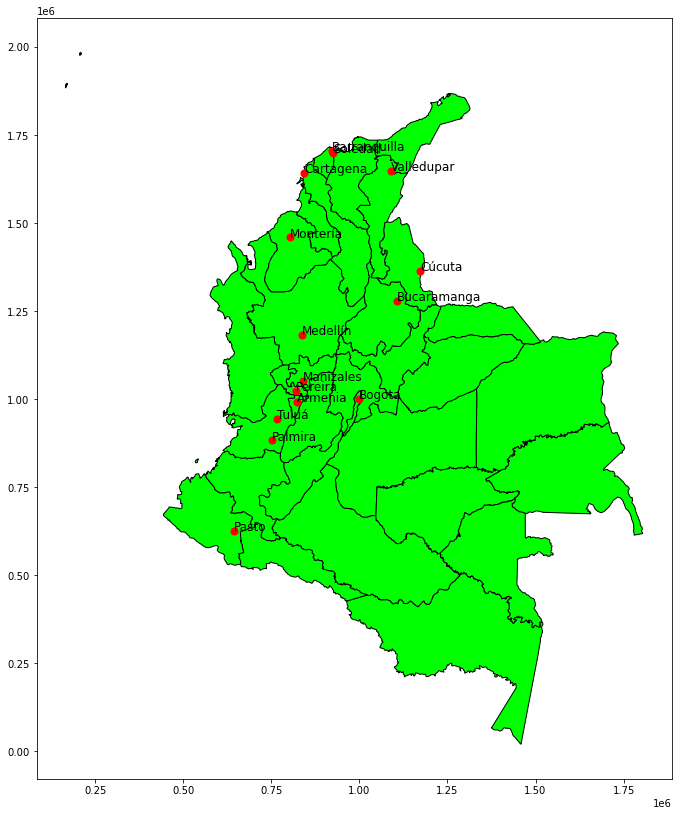

In [17]:
# Cargar el shapefile de Colombia
mapa = gpd.read_file('Colombia Shape\depto.shp')
#print(mapa.crs) #Formato CRS del archivo .shp
fig, ax = plt.subplots(figsize=(14, 14))
mapa.plot(ax=ax, color='lime', edgecolor='black')
df.plot(ax=ax, markersize=50, color='red')
for i, txt in enumerate(df['Ciudad']):
    ax.annotate(txt, (df['geometry'][i].x,df['geometry'][i].y), fontsize=12)



## Matriz De Costos.

Matrices Requeridas:
    
    MATRIZ DE DISTANCIAS ENTRE LAS CIUDADES:MDC

    MATRIZ DE # DE PEJAES ENTRE LAS CIUDADES:MNP

    MATRIZ DE TIEMPO ESTIMADO ENTRE CIUDADES:MTC

Para realizar estos calculos tambien hay que tener en cuenta la informacion del Automovil que se empleara para este problema el cual es un Chevrolet Camaro SS
Este Camaro usa Gasolina como combustible (Inserte Imagen de Camaro)

De este Auto tenemos lo siguiente:

Su rendimeinto en KM por Galon es: 29.15Km/Galon.

El precio de la gasolina a la fecha de realizacion de este trabajo (Marzo 15 del 2023) es de $9.664 Pesos Colombianos por Galon.

EL sueldo por Hora de nuestro chofer a la fecha de realizacion de este trabajo (Marzo 15 del 2023) sera de $1368,39 COP

Nuestro automovil en Colombia pagaria la tarifa de categoria 1. Este costo sera de Aproximadamente $8000 COP

### Matriz de Distancias Entre las ciudades: MDC

Para esto Usaremos la Formula de Haversine que sirve para calcular la distancia en km entre 2 puntos de la tierra el cual nos dara un estimado de las diatancias que requerimos para la solucion de este problema.

In [18]:
#FUNCION DE HAVERSINE
from math import radians, sin, cos, sqrt, atan2
def haversine(coord1, coord2):
    # Radio de la Tierra en km
    R = 6371.0

    # Convertir coordenadas de grados a radianes
    lat1, lon1 = map(radians, coord1)
    lat2, lon2 = map(radians, coord2)

    # Diferencia de latitud y longitud
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distancia entre las dos coordenadas
    distance = R * c

    return distance

In [19]:
# Creamos una matriz vacía de distancias
distances = [[0.0] * len(coords) for i in range(len(coords))]

# Calcular la distancia entre cada par de ciudades
for i in range(len(coords)):
    for j in range(i + 1, len(coords)):
        # Calcular la distancia entre las coordenadas
        dist = haversine(coords[i], coords[j])

        # Almacenar la distancia en la matriz y los redondeamos a 2 decimales
        distances[i][j] = round(dist,2)
        distances[j][i] = round(dist,2)

# Imprimir la matriz de distancias
#for i in range(len(ciudades)):
 #   print(ciudades[i], distances[i])
#convertimos la lista en una matriz 15X15
MDC = np.array(distances).reshape(15,15) 
MDC



array([[   0.  ,  280.49,   61.8 ,  273.66,  156.85,  130.36,  191.11,
         840.18,  581.04,  837.86,  767.78,  842.95,  312.55,  532.17,
         640.89],
       [ 280.49,    0.  ,  341.26,  518.46,  437.24,  409.72,  471.28,
        1120.66,  851.99, 1114.34, 1039.94, 1119.27,  591.73,  803.06,
         911.8 ],
       [  61.8 ,  341.26,    0.  ,  241.51,   98.12,   75.81,  132.76,
         779.9 ,  519.7 ,  776.06,  706.2 ,  781.14,  250.93,  479.72,
         587.92],
       [ 273.66,  518.46,  241.51,    0.  ,  180.33,  177.48,  167.06,
         657.24,  501.23,  705.52,  662.89,  711.25,  245.45,  299.28,
         404.5 ],
       [ 156.85,  437.24,   98.12,  180.33,    0.  ,   31.12,   34.63,
         683.44,  437.99,  686.56,  621.5 ,  691.8 ,  160.63,  383.75,
         491.38],
       [ 130.36,  409.72,   75.81,  177.48,   31.12,    0.  ,   62.19,
         711.52,  469.11,  717.07,  652.51,  722.33,  191.47,  404.1 ,
         512.45],
       [ 191.11,  471.28,  132.76,  167.

Ahora Procedemos a las creacion de las matrices MNP y MTC las que corresponden al numero de peajes entre ciudades y el tiempo para viajar de una ciudad a otra

In [20]:
#procedemos a convertir los archivos .xlsx a matrices 
# Cargar el archivo de Excel en un DataFrame
Peajes = pd.read_excel('PeajesSimples.xlsx',header=None)

# Convertir el DataFrame en un array de NumPy
MNP = Peajes.to_numpy()

Tiempos = pd.read_excel('TiemposSimples.xlsx', header=None) #en Total de Minutos

# Convertir el DataFrame en un array de NumPy
MTC = Tiempos.to_numpy()

print(MNP.shape)
print(MTC.shape)


(15, 15)
(15, 15)


Con estas 3 matrices ya calculadas damos luz para la matriz de costos totales de movilizacion entre ciudades la denotaremos MCTC

In [21]:
#Datos usados para los caclculos
Vh = 1368.39 # Salrio de una hora de sueldo del chofer
Cpc1 = 8000 # Costo Aproximado de los peajes (Esto puede variar mucho o poco entre peajes para la practicidad del ejercicio se fijo).
Pg = 9.664 # PRecio del Galon de Combustible

#Realizamos alguno Ajustes en las matrices 
Txh = MTC/60 # Convertimos los minutos en horas
Dxg = MDC/29.15 # Con esta operacion conseguimos el numero de kilometros por galon 

#FINALMENTE Calculamos la matriz MCTC

MCTC = Vh*Txh + MNP*8000 + Pg*Dxg 

print(MCTC.shape)


(15, 15)


## Problema del Viajero Colombian Version: Colonias De Hormigas

Beginning ACO Optimization with 100 iterations...
Best score at iteration 0: 988660.5; overall: 988660.5 (0s)
Best score at iteration 1: 828915.94; overall: 828915.94 (0s)
Best score at iteration 2: 1071197.19; overall: 828915.94 (0s)
Best score at iteration 3: 1146182.58; overall: 828915.94 (0s)
Best score at iteration 4: 919619.76; overall: 828915.94 (0s)
Best score at iteration 5: 1045982.59; overall: 828915.94 (0s)
Best score at iteration 6: 941627.0; overall: 828915.94 (0s)
Best score at iteration 7: 991432.28; overall: 828915.94 (0s)
Best score at iteration 8: 1087486.12; overall: 828915.94 (0s)
Best score at iteration 9: 1062377.46; overall: 828915.94 (0s)
Best score at iteration 10: 835900.64; overall: 828915.94 (0s)
Best score at iteration 11: 977302.7; overall: 828915.94 (0s)
Best score at iteration 12: 1005611.81; overall: 828915.94 (0s)
Best score at iteration 13: 1070237.37; overall: 828915.94 (0s)
Best score at iteration 14: 919887.19; overall: 828915.94 (0s)
Best score a

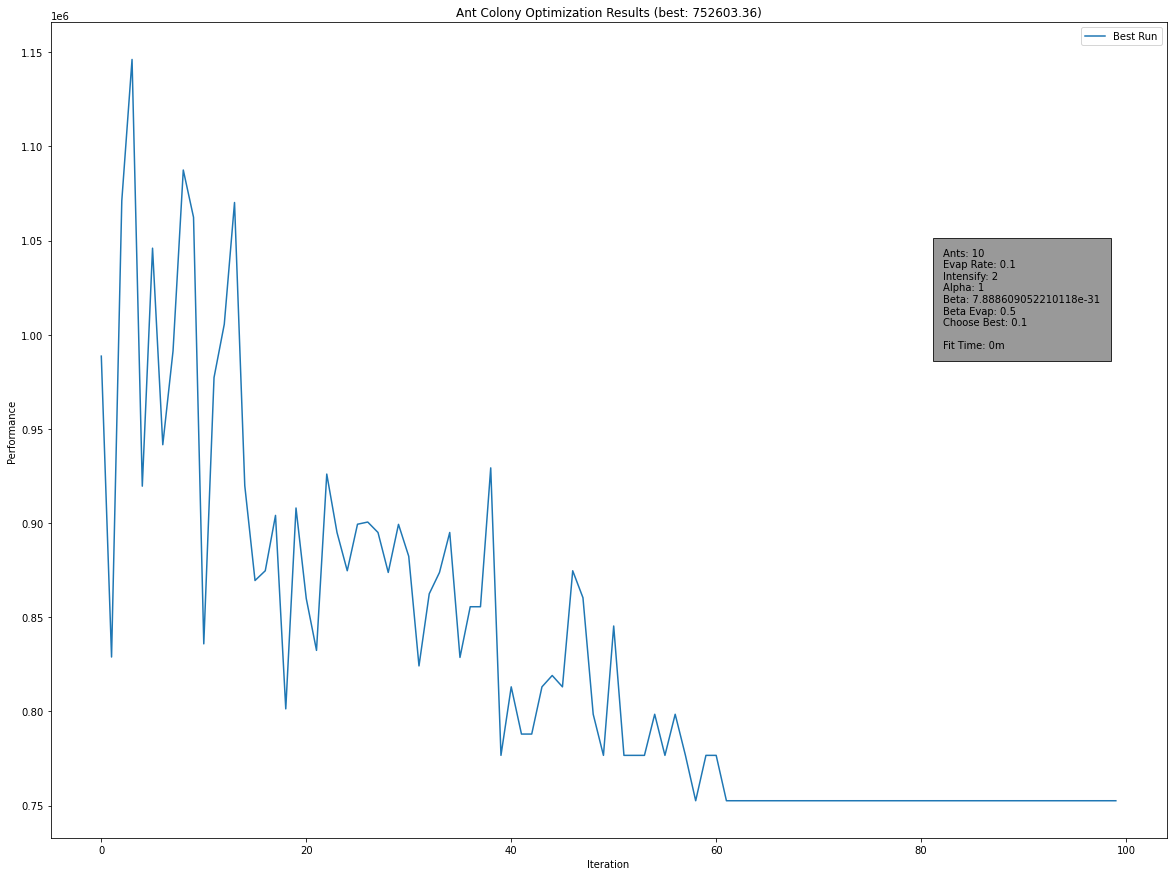

Beginning ACO Optimization with 100 iterations...
Best score at iteration 0: 751251.07; overall: 751251.07 (0s)
Best score at iteration 1: 875627.41; overall: 751251.07 (0s)
Best score at iteration 2: 804745.6; overall: 751251.07 (0s)
Best score at iteration 3: 948178.35; overall: 751251.07 (0s)
Best score at iteration 4: 947779.48; overall: 751251.07 (0s)
Best score at iteration 5: 915064.63; overall: 751251.07 (0s)
Best score at iteration 6: 1064694.26; overall: 751251.07 (0s)
Best score at iteration 7: 758081.69; overall: 751251.07 (0s)
Best score at iteration 8: 749510.77; overall: 749510.77 (0s)
Best score at iteration 9: 888666.73; overall: 749510.77 (0s)
Best score at iteration 10: 864889.7; overall: 749510.77 (0s)
Best score at iteration 11: 719363.91; overall: 719363.91 (0s)
Best score at iteration 12: 861693.7; overall: 719363.91 (0s)
Best score at iteration 13: 822360.43; overall: 719363.91 (0s)
Best score at iteration 14: 719363.91; overall: 719363.91 (0s)
Best score at ite

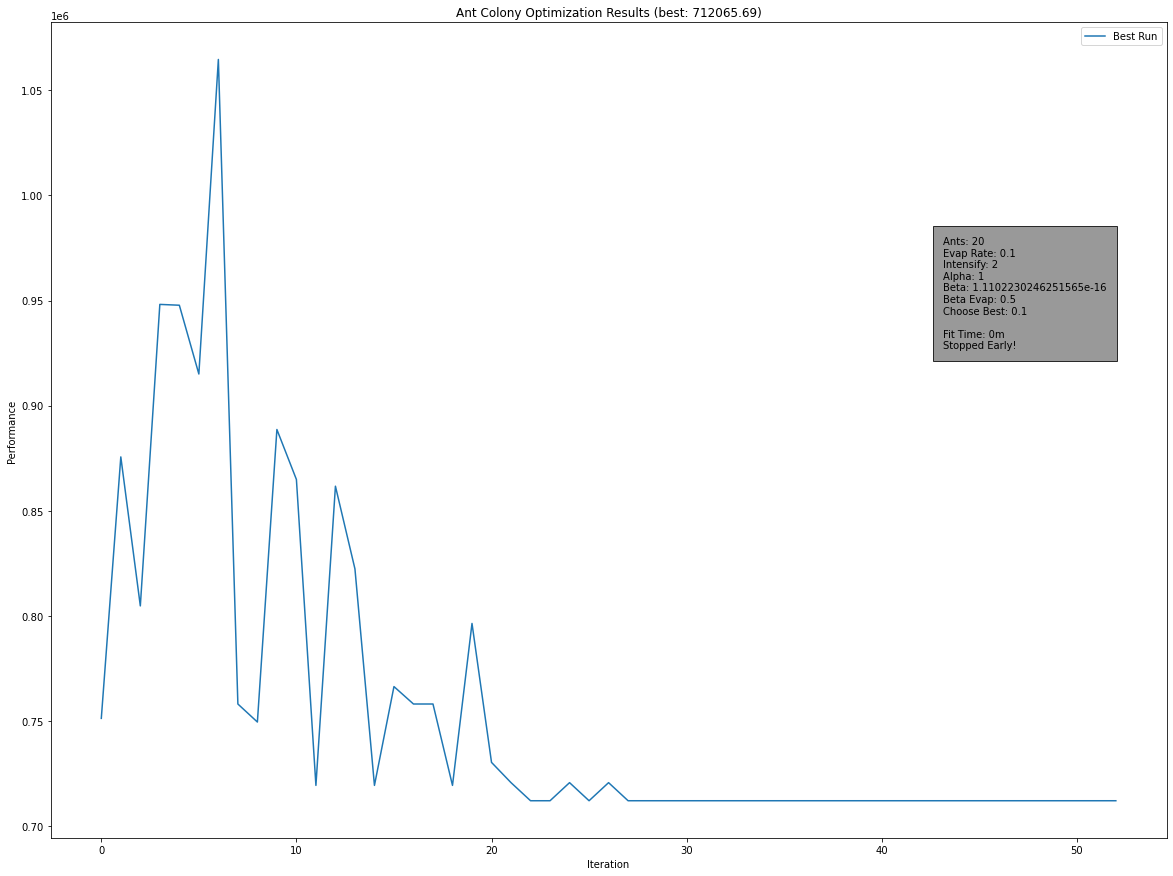

Beginning ACO Optimization with 100 iterations...
Best score at iteration 0: 862294.41; overall: 862294.41 (0s)
Best score at iteration 1: 780609.99; overall: 780609.99 (0s)
Best score at iteration 2: 816023.66; overall: 780609.99 (0s)
Best score at iteration 3: 845929.07; overall: 780609.99 (0s)
Best score at iteration 4: 948080.68; overall: 780609.99 (0s)
Best score at iteration 5: 898109.73; overall: 780609.99 (0s)
Best score at iteration 6: 811315.42; overall: 780609.99 (0s)
Best score at iteration 7: 816119.71; overall: 780609.99 (0s)
Best score at iteration 8: 819463.84; overall: 780609.99 (0s)
Best score at iteration 9: 759408.38; overall: 759408.38 (0s)
Best score at iteration 10: 800750.81; overall: 759408.38 (0s)
Best score at iteration 11: 757245.66; overall: 757245.66 (0s)
Best score at iteration 12: 791660.26; overall: 757245.66 (0s)
Best score at iteration 13: 758201.05; overall: 757245.66 (0s)
Best score at iteration 14: 757245.66; overall: 757245.66 (0s)
Best score at i

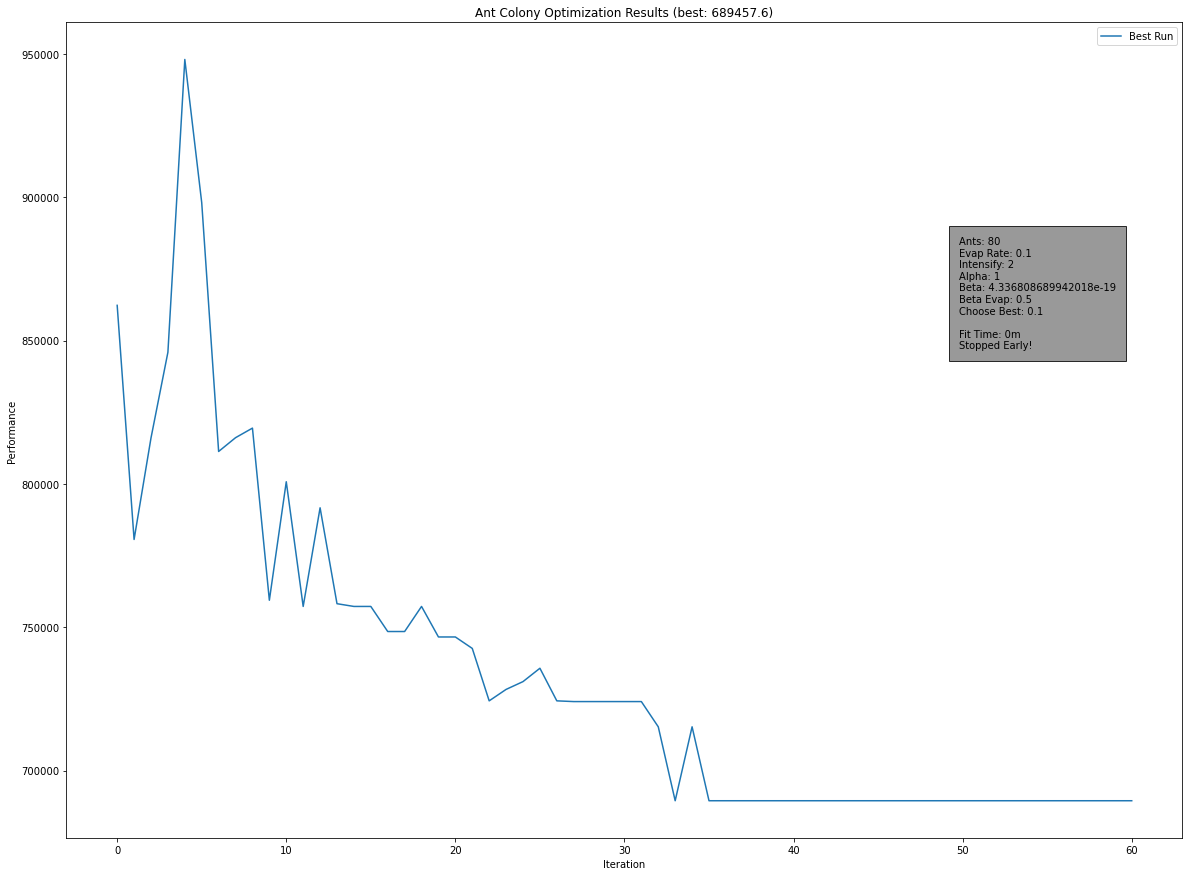

Beginning ACO Optimization with 100 iterations...
Best score at iteration 0: 851395.35; overall: 851395.35 (0s)
Best score at iteration 1: 894773.11; overall: 851395.35 (0s)
Best score at iteration 2: 828944.82; overall: 828944.82 (0s)
Best score at iteration 3: 831484.56; overall: 828944.82 (0s)
Best score at iteration 4: 774431.83; overall: 774431.83 (0s)
Best score at iteration 5: 768182.25; overall: 768182.25 (0s)
Best score at iteration 6: 731413.71; overall: 731413.71 (0s)
Best score at iteration 7: 800668.65; overall: 731413.71 (0s)
Best score at iteration 8: 790422.19; overall: 731413.71 (0s)
Best score at iteration 9: 704624.81; overall: 704624.81 (0s)
Best score at iteration 10: 775511.99; overall: 704624.81 (0s)
Best score at iteration 11: 721945.93; overall: 704624.81 (0s)
Best score at iteration 12: 721946.13; overall: 704624.81 (0s)
Best score at iteration 13: 704624.81; overall: 704624.81 (0s)
Best score at iteration 14: 688577.7; overall: 688577.7 (0s)
Best score at ite

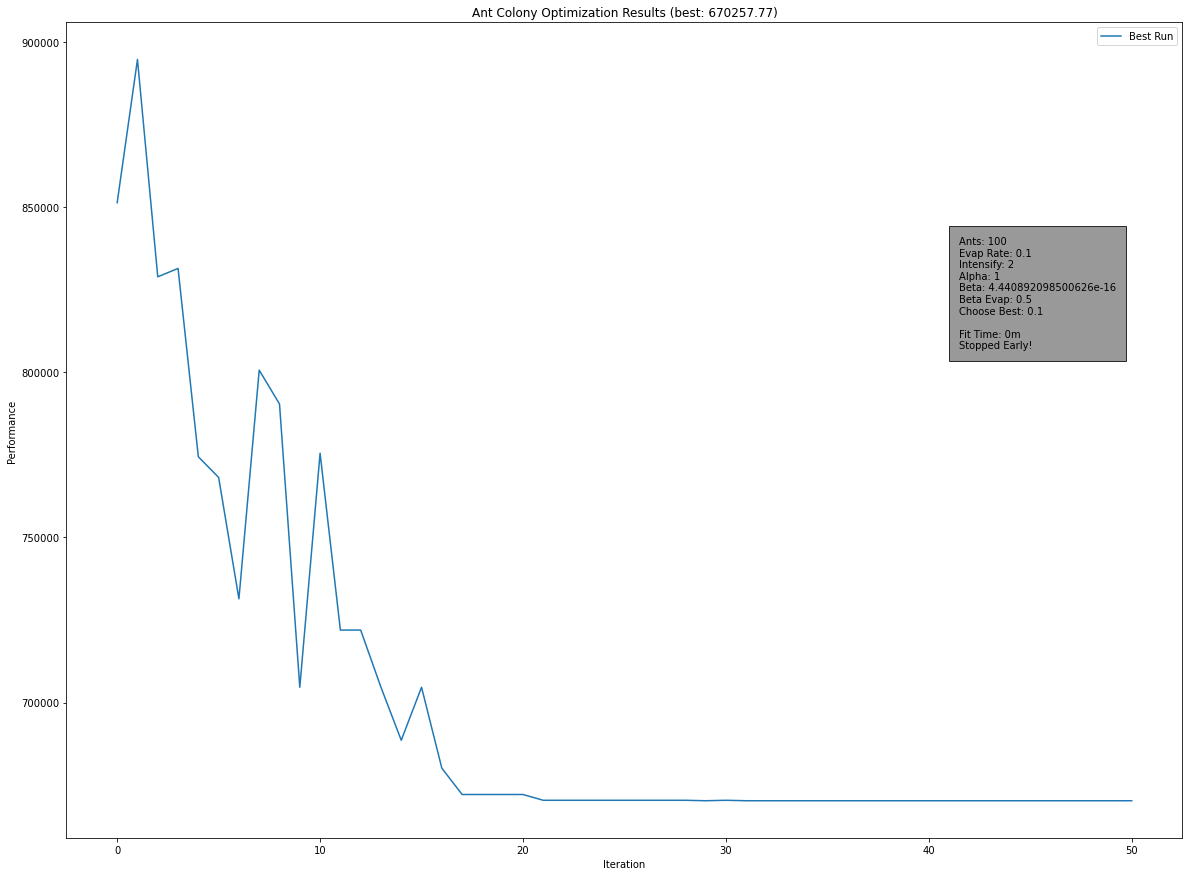

Beginning ACO Optimization with 100 iterations...
Best score at iteration 0: 750265.29; overall: 750265.29 (0s)
Best score at iteration 1: 677047.87; overall: 677047.87 (0s)
Best score at iteration 2: 857532.29; overall: 677047.87 (0s)
Best score at iteration 3: 865571.72; overall: 677047.87 (0s)
Best score at iteration 4: 852345.89; overall: 677047.87 (0s)
Best score at iteration 5: 839770.2; overall: 677047.87 (0s)
Best score at iteration 6: 837024.27; overall: 677047.87 (0s)
Best score at iteration 7: 759429.23; overall: 677047.87 (0s)
Best score at iteration 8: 740938.35; overall: 677047.87 (0s)
Best score at iteration 9: 735083.56; overall: 677047.87 (0s)
Best score at iteration 10: 706072.33; overall: 677047.87 (0s)
Best score at iteration 11: 676259.0; overall: 676259.0 (0s)
Best score at iteration 12: 668281.37; overall: 668281.37 (0s)
Best score at iteration 13: 666529.07; overall: 666529.07 (0s)
Best score at iteration 14: 668281.37; overall: 666529.07 (0s)
Best score at iter

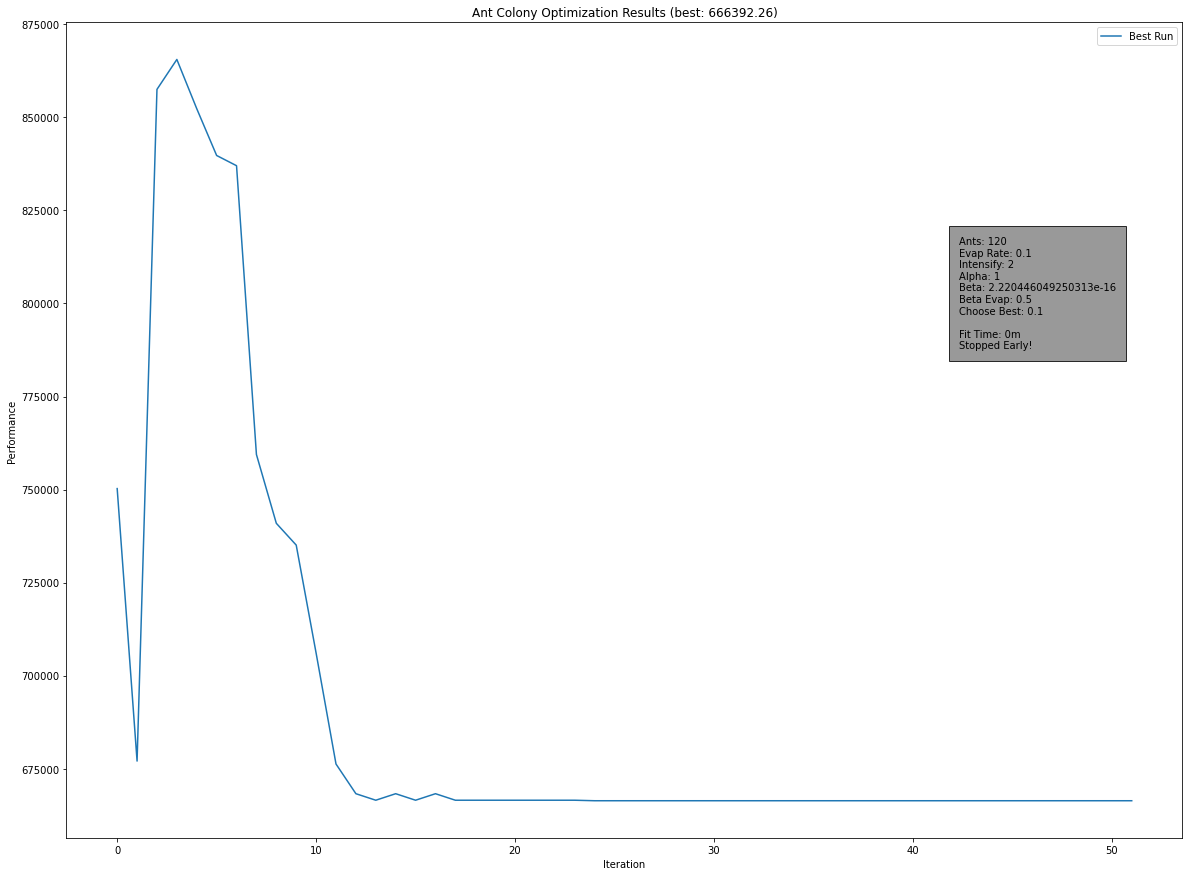

In [22]:
problem = MCTC # matriz de costos totales
Hormigas=[10,20,80,100,120] # nuemro de Hormigas a evaluar 
MejorRuta=[] #Guardamos la ruta
for i in range(len(Hormigas)):
    
    optimizer = AntColonyOptimizer(ants=Hormigas[i], evaporation_rate=.1, intensification=2, alpha=1, beta=1,
                                beta_evaporation_rate=0.5, choose_best=.1)
    best = optimizer.fit(problem, 100) # Iniciamos el optimizador con 100 iteraciones
    optimizer.plot()
    MejorRuta.append(optimizer.best_path) #Agregamos la mejor ruta por cada numero de Hormigas



Calculamos el costo total del recorrido

In [23]:
def costo_total(ruta, costos):
    costo = 0
    for i in range(len(ruta) - 1):
        costo += MCTC[ruta[i]][ruta[i+1]]
    return costo

for i in range(len(MejorRuta)):
    print("El costo total de la ruta es: $", round(costo_total(MejorRuta[i], MCTC), 2), " COP para un total de ", Hormigas[i], "Hormigas")

El costo total de la ruta es: $ 752603.36  COP para un total de  10 Hormigas
El costo total de la ruta es: $ 712065.69  COP para un total de  20 Hormigas
El costo total de la ruta es: $ 689457.6  COP para un total de  80 Hormigas
El costo total de la ruta es: $ 670257.77  COP para un total de  100 Hormigas
El costo total de la ruta es: $ 666392.26  COP para un total de  120 Hormigas


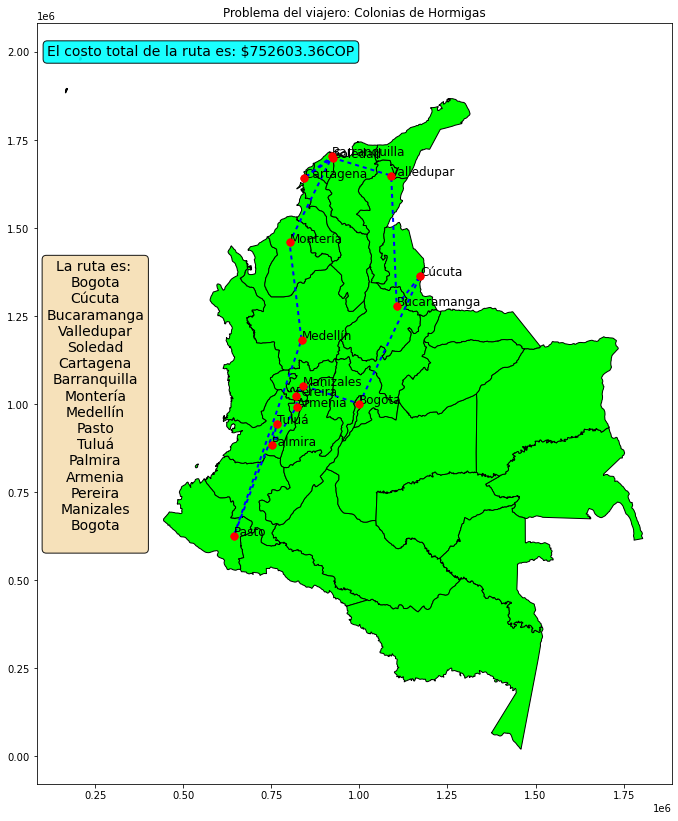

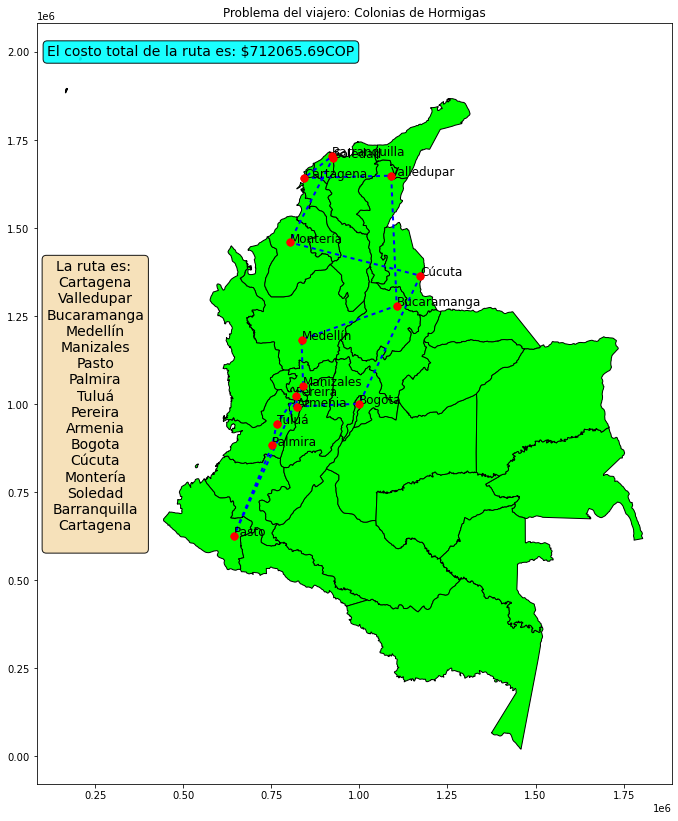

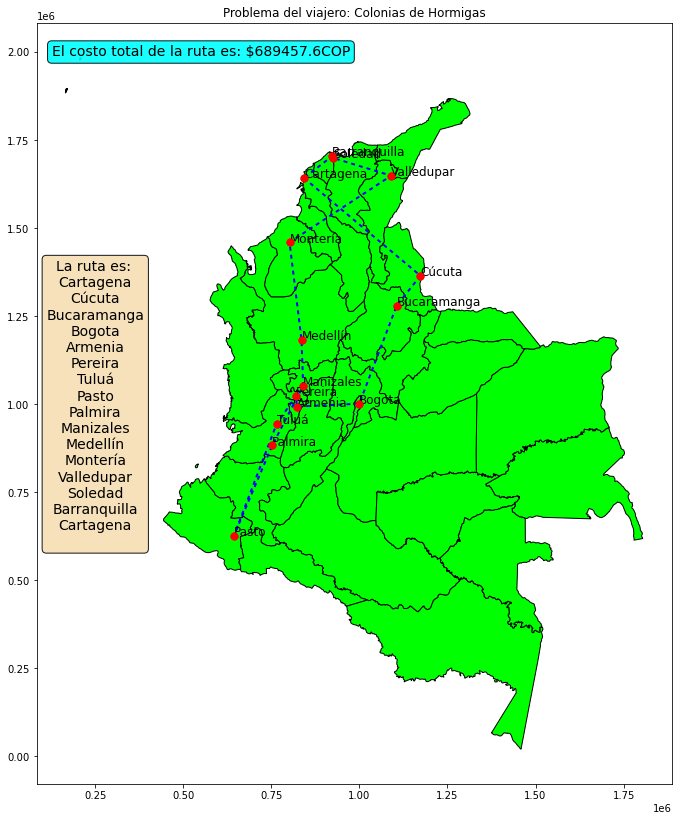

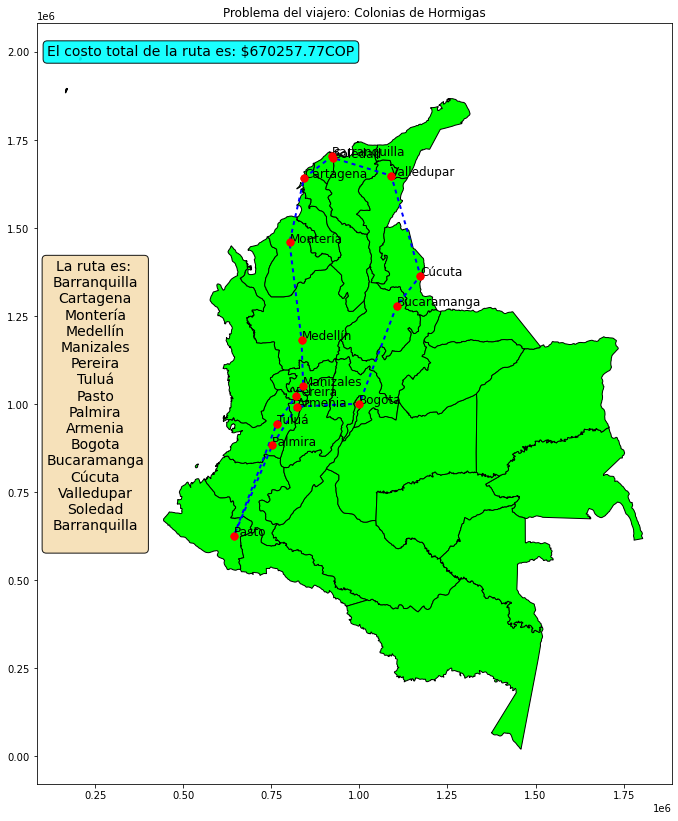

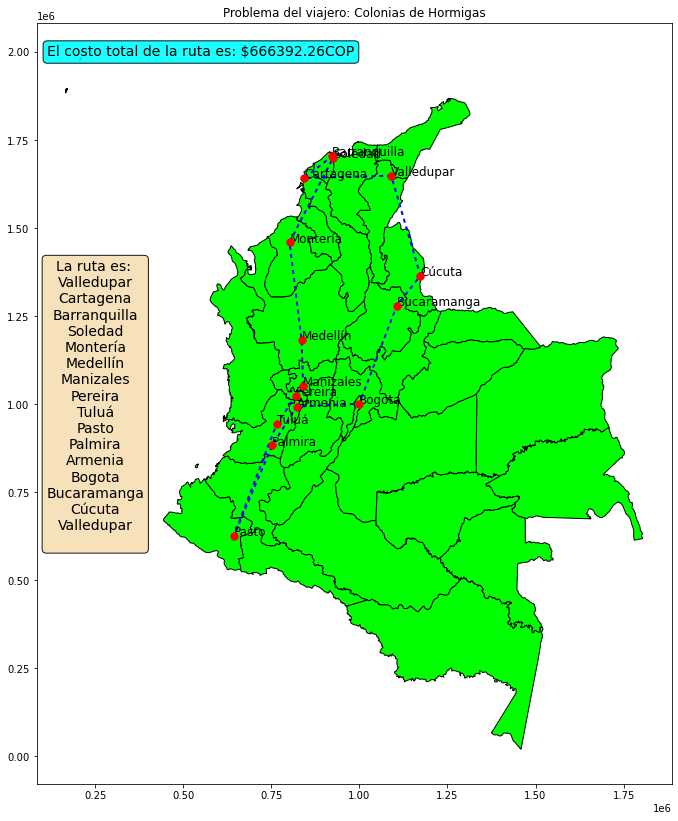

In [24]:
#Cada vez que ejecutemos esta celda y el script en general borramos los archivos para que no se acumulen plot de otras seseiones
folder_path = "GifVCH"
for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)
# Lista para almacenar las rutas de las rutas de las imágenes PNG
ruta_imagenes = []

for i in range(len(MejorRuta)):
    texto = "La ruta es: "+"\n"  # texto inical para añadir las rutas al plot
    texto2 = "El costo total de la ruta es: $" + str(round(costo_total(MejorRuta[i], MCTC), 2))+"COP"  # Texto para añadir el valor de la ruta

    current_sol = MejorRuta[i]  # Obtenbemos la soulcion por iteracion
    for j in range(len(current_sol)):
        texto += str(ciudades[current_sol[j]])+"\n"

    # Aqui obtenemos la ruta segun sea la solucion
    rutacol = [df.iloc[i]['geometry']for i in MejorRuta[i]]
    #creamos el plot de la ruta
    fig, ax = plt.subplots(figsize=(14, 14))
    mapa.plot(ax=ax, color='lime', edgecolor='black')
    df.plot(ax=ax, markersize=50, color='red')
    for i, txt in enumerate(df['Ciudad']):
        ax.annotate(txt, (df['geometry'][i].x,
                    df['geometry'][i].y), fontsize=12)
    df.plot(ax=plt.gca(), color='red', markersize=50, zorder=3)
    plt.plot([p.x for p in rutacol], [p.y for p in rutacol],
             color='blue', linestyle='--', linewidth=2, dashes=[2, 2], zorder=2)
    plt.text(250000, 1000000, texto, ha='center', va='center', size=14,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    plt.text(550000, 2000000, texto2, ha='center', va='center', size=14,
             bbox=dict(boxstyle='round', facecolor='cyan', alpha=0.9))
    plt.title("Problema del viajero: Colonias de Hormigas")
    # Generar un nombre de archivo único con un número aleatorio
    nombre_archivo = f"GifVCH/imagen_{i}_{random.randint(0, 100000)}.png"
    texto = ""
    # Agregar la ruta de la imagen PNG a la lista
    ruta_imagenes.append(nombre_archivo)

    # Guardar la figura como imagen PNG
    plt.savefig(nombre_archivo)

# Crear archivo GIF a partir de las imágenes PNG
with imageio.get_writer('GifVCH/animacionCH.gif', mode='I', duration=0.8) as writer:
    for ruta in ruta_imagenes:
        image = imageio.imread(ruta)
        writer.append_data(image)
